### Import libraries

In [17]:
import numpy as np
import json
import re
import tensorflow as tf
import random
import spacy
nlp = spacy.load('en_core_web_sm')

### Import json file

In [18]:
with open('intents_2.json') as f:
    intents = json.load(f)

### Preprocessing data
In this part we gonna clean data, split them into inputs and targets tensor, build a tokenizer dictionary and turn sentences into sequences.
The target tensor has a bunch of list with a length of unique title list.

In [19]:
def preprocessing(line):
    line = re.sub(r'[^a-zA-z.?!\']', ' ', line)
    line = re.sub(r'[ ]+', ' ', line)
    return line

In [20]:
def isString(x):
  return isinstance(x, str)

In [21]:
def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))

In [22]:
# get text and intent title from json data
inputs, targets = [], []
classes = []
intent_doc = {}

for intent in intents['intents']:
    if(isString(intent['tag'])):
      if intent['tag'] not in classes:
        classes.append(intent['tag'])
      if intent['tag'] not in intent_doc:
        intent_doc[intent['tag']] = []
    else:
      tag = listToString(intent['tag'])
      if tag not in classes:
        classes.append(tag)
      if tag not in intent_doc:
        intent_doc[tag] = []
        
    for text in intent['patterns']:
        inputs.append(preprocessing(text))
        targets.append(intent['tag'])

In [23]:
def tokenize_data(input_list):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<unk>')
    
    tokenizer.fit_on_texts(input_list)
    
    input_seq = tokenizer.texts_to_sequences(input_list)

    input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, padding='pre')
    
    return tokenizer, input_seq

# preprocess input data
tokenizer, input_tensor = tokenize_data(inputs)

In [24]:
def create_categorical_target(targets):
    word={}
    categorical_target=[]
    counter=0
    for trg in targets:
        x = trg[0]
        if x not in word:
            word[x]=counter
            counter+=1
        categorical_target.append(word[x])
    
    categorical_tensor = tf.keras.utils.to_categorical(categorical_target, num_classes=len(word), dtype='int32')
    return categorical_tensor, dict((v,k) for k, v in word.items())

# preprocess output data
target_tensor, trg_index_word = create_categorical_target(targets)

In [25]:
print('input shape: {} and output shape: {}'.format(input_tensor.shape, target_tensor.shape))

input shape: (1457, 39) and output shape: (1457, 221)


### Build the model

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(input_tensor,target_tensor,test_size=0.15)

In [39]:
# hyperparameters
epochs=50
vocab_size=len(tokenizer.word_index) + 1
embed_dim=256
units=128
target_length=target_tensor.shape[1]

In [42]:
# build RNN Model with tensorflow
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim),
    tf.keras.layers.LSTM(units, dropout=0.3),
    tf.keras.layers.Dense(units, activation='tanh'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.3),
     tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(target_length, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 256)         256256    
                                                                 
 lstm_6 (LSTM)               (None, 128)               197120    
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 64)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [43]:
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

# train the model
# model.fit(input_tensor, target_tensor, epochs=epochs)
from keras.callbacks import History
history = History()
m = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size = 5,
                   epochs = 50, callbacks = [history]) 

Epoch 1/50
248/248 [==============================] - 7s 18ms/step - loss: 4.8843 - accuracy: 0.0291 - val_loss: 4.3036 - val_accuracy: 0.0594
Epoch 2/50
248/248 [==============================] - 4s 15ms/step - loss: 3.8149 - accuracy: 0.0985 - val_loss: 3.5702 - val_accuracy: 0.2283
Epoch 3/50
248/248 [==============================] - 4s 15ms/step - loss: 3.1487 - accuracy: 0.2221 - val_loss: 2.8318 - val_accuracy: 0.4292
Epoch 4/50
248/248 [==============================] - 4s 15ms/step - loss: 2.5506 - accuracy: 0.3643 - val_loss: 2.3635 - val_accuracy: 0.5434
Epoch 5/50
248/248 [==============================] - 4s 15ms/step - loss: 2.0648 - accuracy: 0.4774 - val_loss: 2.0119 - val_accuracy: 0.6438
Epoch 6/50
248/248 [==============================] - 4s 15ms/step - loss: 1.8019 - accuracy: 0.5380 - val_loss: 1.7705 - val_accuracy: 0.6621
Epoch 7/50
248/248 [==============================] - 4s 15ms/step - loss: 1.5267 - accuracy: 0.6187 - val_loss: 1.6574 - val_accuracy: 0.7123

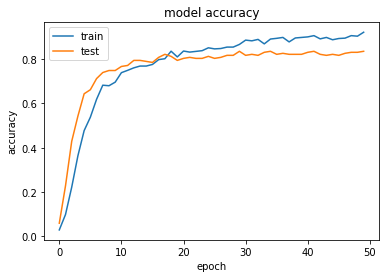

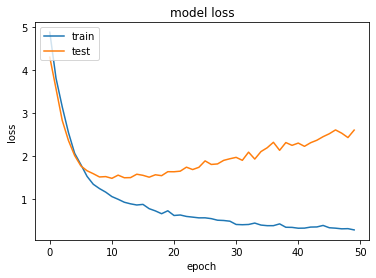

In [44]:
import matplotlib.pyplot as plt
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')